<!-- ### Dual formulation

I solve here the smoothed dual problem : 
$$
\max_{\mathbf{\alpha} \in \mathbf{R}^m, \mathbf{\beta} \in \mathbf{R}^n} \mathbf{\alpha}^{\top} \mathbf{a} + \mathbf{\beta}^{\top} b - \sum\limits_{j = 1}^{n}\delta_{\Omega}(\mathbf{\alpha} + \beta_j \mathbf{1}_m - \mathbf{c}_{\cdot,j})
$$
A L-BFGS method is applied. -->

### Linear programming for regular OT

Set up for linear programming of regular OT, in particular $t \in \mathbf{R}^{nm}$, $A \in \mathcal{M}_{n + m,nm}(\mathbf{R})$ , and $d \in \mathbf{R}^{n + m}$. The goal is here to solve : 
$$
\min_{t \in \mathbf{R}^{nm}} c^{\top}t \\
s.t \quad At = d \\
\quad \quad t \geq 0
$$

We note $m = n_{\text{src}}$ et $n = n_{\text{ref}}$. So the transport plan is $T \in \mathcal{M}^{n\times m}$

In [1]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy as sc
from scipy.sparse import csr_matrix, identity
from sklearn.metrics.pairwise import euclidean_distances
from dataclasses import dataclass
import cvxpy as cp
from collections.abc import Callable
from utils import *
import pickle
from abc import ABC, abstractmethod
import sys
import os

In [467]:
@dataclass
class Image_d:
    FNAME: str

    def extract_image(self):
        path = os.path.join(os.getcwd() + '\img', self.FNAME)
        img = Image.open(path).convert('RGB')
        img_array = np.asarray(img)

        #Dimension of the image
        self.width = img_array.shape[0]
        self.length = img_array.shape[1]

        r_ref, g_ref, b_ref = np.transpose(img_array, axes = (2,0,1))
        self.img_array = np.dstack([r_ref, g_ref, b_ref])
        self.img = Image.fromarray(self.img_array, 'RGB')
        return self

    @staticmethod
    def display(label, *img_l):
        if label is None:
            if len(img_l) > 1:
                fig, ax = plt.subplots(1, len(img_l), figsize = (10,10))
                for i, img_ in enumerate(img_l):
                    ax[i].imshow(img_.img)
                    ax[i].axis("off")
                else:
                    plt.imshow(img_l[0].img)
                    plt.axis("off")
        else:
            assert len(img_l) == len(label), "Every images should be labeled"
            if len(img_l) > 1:
                fig, ax = plt.subplots(1, len(img_l), figsize = (10,10))
                for i, img_ in enumerate(img_l):
                    ax[i].imshow(img_.img)
                    ax[i].axis("off")
                    ax[i].set_title(label[i])
            else:
                plt.imshow(img_l[0].img, label = label[0])
                plt.axis("off")
                plt.title(label[0])

    def flatten(self):
        size = self.img_array.shape
        return np.reshape(self.img_array, (size[0]*size[1], size[-1]))

    def fit_kmeans(self, n_clusters: int = 100):
        colors_array = self.flatten()
        self.kmeans_cluster = KMeans(n_clusters = n_clusters, random_state = 0, n_init = "auto").fit(colors_array)
        label_ = self.kmeans_cluster.labels_
        count, bins = np.histogram(label_, bins = range(self.kmeans_cluster.n_clusters + 1))
        self.hist = (count, bins)

    def plot_histogram(self, label: str = None):
        label_ = self.kmeans_cluster.labels_
        plt.hist(label_, density=False, label = self.FNAME if label is None else label, bins = "auto")
        plt.legend()
        plt.xlabel("N° of clusters")

class Optimal_Transport(ABC):
    def __init__(self, image_src: Image_d, image_ref: Image_d):
        self.img_src = image_src
        self.img_ref = image_ref
        
        self.T_map = None
        self.c = None

        self.loss_history = []

    @abstractmethod
    def solve(self, save: bool):
        pass
    
    def cost_matrix(self):
        c = np.empty((n_ref,n_src))
        for i in range(n_ref): #Nombre de lignes
            for j in range(n_src): #Nombre de colonnes
                c[i, j] = dist(self.img_src.kmeans_cluster.cluster_centers_[j]/256, self.img_ref.kmeans_cluster.cluster_centers_[i]/256)
        self.c = c

    @abstractmethod
    def cost(self, *args):
        pass
    
    @abstractmethod
    def compute_optimal_map(self):
        pass

    def print_sparsity(self):
        assert self.T_map is not None, "Transport plan have not been computed yet"
        self.sparsity = np.count_nonzero(self.T_map < 1e-7)/np.prod(self.T_map.shape)
        print(f"The transport map is {self.sparsity*100}% sparse")

    def print_OT_map(self):
        if len(self.T_map) == 1:
            self.T_map = np.reshape(self.T_map, (self.img_ref.kmeans_cluster.n_clusters, self.img_src.kmeans_cluster.n_clusters))
        fig = plt.figure(figsize=(7,7))
        plt.imshow(self.T_map)
        plt.axis("off")
        plt.title("Optimal Transport plan")
        
    def load(self, file_name: str):
        with open(file_name, 'rb') as f:
            self.T_map = pickle.load()

    def plot_img_transp(self, ax = None):
        assert self.T_map is not None, "Optimal transport plan should be computed first."
        cluster_center_new_dual = mean_vector(self.T_map, img_src.kmeans_cluster.cluster_centers_/256)
        image_n = cluster_center_new_dual[img_ref.kmeans_cluster.labels_]
        image_n = image_n.reshape(img_ref.width, img_ref.length, 3)

        fig = plt.figure(figsize=(7,7))
        if ax is None:
            plt.imshow(image_n)
            plt.axis("off")
        else:
            ax.imshow(image_n)
            plt.axis("off")

class Regular_OT(Optimal_Transport):
    def __init__(self, img_src: Image_d, img_ref: Image_d):
        super().__init__(img_src, img_ref)

    def compute_optimal_map(self):
        pass

    @staticmethod
    def set_constraint(m,n):
        """
        Build here all the equality constraints for regular OT
        Args : 
            m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
            n : number of constraints (i.e number of cluster colors) for source image (int n_ref)
        Output:
            Matrix for first set of constraints A1 and second set of constraints
        """
        A1 = np.zeros((m,n*m)) #equality for a
        A2 = np.zeros((n,n*m)) #equality for b

        for j in range(n):
            for i in range(0,n*m,n):
                A2[j, j + i] = 1
        k = 0
        for j in range(m):
            A1[j,k: k + n] = 1
            k += n
        return A1,A2
    
    def cost(self):
        pass

    def solve(self, method: str='ECOS', save: bool = False):
        n_ref = self.img_ref.kmeans_cluster.n_clusters
        n_src = self.img_src.kmeans_cluster.n_clusters

        a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
        b = self.img_src.hist[0]/np.sum(img_src.hist[0])

        if self.c is None:
            self.cost_matrix()
        d = np.concatenate((a,b), axis = 0)
        t = cp.Variable(n_ref*n_src)
        A1, A2 = self.set_constraint(n_ref,n_src)
        A = np.concatenate((A1,A2))

        prob = cp.Problem(cp.Minimize(np.ravel(self.c)@t),
                 [A @ t == d, t >= 0])
        prob.solve(solver='ECOS')
        self.T_map = np.reshape(t.value, (n_ref, n_src))
        self.value = prob.value
        
        if save:
            with open(f'Regular_OT_solution_{gamma}.pkl', 'wb') as f:
                pickle.dump(self.T_map, f)

class Entropy_OT(Optimal_Transport):
    def __init__(self, img_src: Image_d, img_ref: Image_d, save: bool = False):
        super().__init__(img_src, img_ref)
        self.img_src = img_src
        self.img_ref = img_ref

        self.T_opt = None #True transport plan

        self.loss_history = []

    def cost(self):
        pass

    def compute_optimal_map(self):
        ROT = Regular_OT(img_src, img_ref)
        ROT.solve()
        self.T_opt = ROT.T_map

    def solve(self, u_init: np.ndarray, v_init: np.ndarray, gamma: float, save: bool=False, plot_loss : bool = False):
        if self.c is None :
            self.cost_matrix()
        a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
        b = self.img_src.hist[0]/np.sum(img_src.hist[0])

        if plot_loss and self.T_opt is None:
            self.compute_optimal_map()

        @clock
        def sinkhorn(u_init, v_init, eps):
            """
            Compute Sinkhorn algorithm
            Args:
                u_init : initial vector for u (list m)
                v_init : initial vector for v (list n)
                eps : value under which one breaks the loop
            Outputs : 
                Transport plan and optimal objective function, error to the true transportation plan T*, number of iteration
            """
            K = np.exp(-self.c/gamma) #definition of the Gibbs Kernel
            P = np.diag(u_init) @ K @ np.diag(v_init)
            p_criteria = 2*P
            u = u_init
            v = v_init
            n_iter = 0
            while (np.abs((np.trace(P.T @ P) - np.trace(p_criteria.T @ p_criteria)))/np.trace(p_criteria.T @ p_criteria) > eps):

                v_p = np.dot(K,v)
                u = np.array([a[i]/v_p[i] for i in range(n_ref)])

                u_p = np.dot(np.transpose(K),u)
                v = np.array([b[i]/u_p[i] for i in range(n_src)])

                p_criteria = P
                P = np.diag(u) @ K @ np.diag(v)

                if plot_loss:
                    self.loss_history.append(np.linalg.norm(P - self.T_opt))

                n_iter += 1
            return P, np.trace(P.T @ self.c), n_iter
        P, objective, n_iter = sinkhorn(u_init, v_init, eps)
        self.T_map = P
        self.value = objective
        return n_iter

class Dual_OT(Optimal_Transport):
    def __init__(self, img_src: Image_d, img_ref: Image_d, method: str = 'BFGS'):
        super().__init__(img_src, img_ref)
        self.method = method

        self.T_opt = None #True transport plan
        self.loss_history=[]

    def compute_optimal_map(self):
        ROT = Regular_OT(img_src, img_ref)
        ROT.solve()
        self.T_opt = ROT.T_map

    def cost(self, gamma:float, regul: str, plot_loss: bool):
        n_ref = self.img_ref.kmeans_cluster.n_clusters
        n_src = self.img_src.kmeans_cluster.n_clusters

        a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
        b = self.img_src.hist[0]/np.sum(img_src.hist[0])

        if regul == 'l2':
            def dual_cost(x: list):
                """
                smoothed dual problem for entropic regularization
                Args :
                    x : contains alpha and beta (list n_ref x n_src)
                Outputs :
                    return the function to maximize evaluated at x
                """
                alpha = x[:n_ref]
                beta = x[n_ref:]
                a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
                b = self.img_src.hist[0]/np.sum(img_src.hist[0])
                delta = 0
                grad_alpha = a.copy()
                grad_beta = b.copy()
                for i in range(n_src):
                    inter = alpha + beta[i] - self.c[:,i]
                    delta += conjug_squared_norm(inter, gamma)
                    grad_alpha -= grad_conjug_squared_norm(inter, gamma)
                    grad_beta[i] -= np.sum(grad_conjug_squared_norm(inter, gamma))
                fun = np.dot(alpha,a) + np.dot(beta,b) - delta
                ###
                grad = np.concatenate((grad_alpha, grad_beta))

                if plot_loss:
                    t_sol = np.empty((n_ref,n_src))
                    for i in range(n_src):
                        t_sol[:,i] = grad_conjug_squared_norm(alpha + beta[i]*np.ones(n_ref) - self.c[:,i], gamma)
                    self.loss_history.append(np.linalg.norm(t_sol - self.T_opt))

                return -fun, -grad #There is a minus Because I want to maximize
            return dual_cost
        elif regul == 'entropy':
            def dual_cost(x: list):
                """
                smoothed dual problem for entropic regularization
                Args :
                    x : contains alpha and beta (list n_ref x n_src)
                Outputs :
                    return the function to maximize evaluated at x
                """
                alpha = x[:n_ref]
                beta = x[n_ref:]

                delta = 0
                grad_alpha = a.copy()
                grad_beta = b.copy()
                for i in range(n_src):
                    inter = alpha + beta[i] - self.c[:,i]
                    delta += conjug_entropy(inter, gamma)
                    grad_alpha -= grad_conjug_entropy(inter, gamma)
                    grad_beta[i] -= np.sum(grad_conjug_entropy(inter, gamma))
                fun = np.dot(alpha,a) + np.dot(beta,b) - delta
                ###
                grad = np.concatenate((grad_alpha, grad_beta), axis = 0)

                if plot_loss:
                    t_sol = np.empty((n_ref,n_src))
                    for i in range(n_src):
                        t_sol[:,i] = grad_conjug_entropy(alpha + beta[i]*np.ones(n_ref) - self.c[:,i], gamma)
                    self.loss_history.append(np.linalg.norm(t_sol - self.T_opt))


                return -fun, -grad #There is a minus Because I want to maximize
            return dual_cost


    def solve(self, gamma: float, save: bool = False, regul = 'l2', plot_loss: bool = False):

        if self.c is None: 
            self.cost_matrix()

        if plot_loss and self.T_opt is None:
            self.compute_optimal_map()

        function = self.cost(gamma, regul, plot_loss)
        @clock
        def optimize(function, x0, method = self.method, jac = True):
            return sc.optimize.minimize(function, x0, method = method, jac = jac)
        n_src, n_ref = self.img_src.kmeans_cluster.n_clusters, self.img_ref.kmeans_cluster.n_clusters
        x0 = np.zeros((n_src + n_ref)) #Starting point is very important
        out = optimize(function, x0, method = self.method, jac = True)
        alpha = out.x[:n_ref]
        beta = out.x[n_ref:]
        t_sol = np.empty((n_ref,n_src))
        if regul == 'entropy':
            for i in range(n_src):
                t_sol[:,i] = grad_conjug_entropy(alpha + beta[i]*np.ones(n_ref) - self.c[:,i], gamma)
        elif regul == 'l2':
            for i in range(n_src):
                t_sol[:,i] = grad_conjug_squared_norm(alpha + beta[i]*np.ones(n_ref) - self.c[:,i], gamma)

        self.T_map = t_sol
        self.value = -function(out.x)[0]

        if save:
            with open(f'dual_OT_solution_{gamma}.pkl', 'wb') as f:
                pickle.dump(self.T_map, f)

class Semi_Dual_OT(Optimal_Transport):
    def __init__(self, img_src: Image_d, img_ref: Image_d, method: str = 'BFGS'):
        super().__init__(img_src, img_ref)
        self.img_src = img_src
        self.img_ref = img_ref
        self.method = method

        self.T_opt = None #True transport plan

        self.loss_history = []

    def compute_optimal_map(self):
        ROT = Regular_OT(img_src, img_ref)
        ROT.solve()
        self.T_opt = ROT.T_map
        del ROT


    def cost(self, gamma: float, regul: str, plot_loss: bool):
        n_src, n_ref = self.img_src.kmeans_cluster.n_clusters, self.img_ref.kmeans_cluster.n_clusters
        if regul == 'l2':
            def function_semi(x: np.ndarray):
                """
                semi dual formulation function
                Args : 
                    x : is alpha (int m)
                Ouputs : 
                    the semi dual formulation evaluated at x
                """
                a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
                b = self.img_src.hist[0]/np.sum(img_src.hist[0])
                val = np.dot(a,x)
                val -= np.sum([b[i]*max_squared_norm(x - self.c[:,i], gamma, b[i]) for i in range(n_src)])
                grad = a.copy()
                for i in range(n_src):
                    grad -= b[i]*grad_max_squared_norm(x - self.c[:,i], gamma, b[i])

                if plot_loss:
                    t_sol_semi = np.empty((n_ref, n_src))
                    for i in range(n_src):
                        t_sol_semi[:,i] = b[i]*grad_max_squared_norm(x - self.c[:,i], gamma, b[i])
                    self.loss_history.append(np.linalg.norm(t_sol_semi - self.T_opt))

                return -val, -grad
            return function_semi

        elif regul == "entropy":
            def function_semi(x: np.ndarray):
                """
                semi dual formulation function
                Args : 
                    x : is alpha (int m)
                Ouputs : 
                    the semi dual formulation evaluated at x
                """
                a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
                b = self.img_src.hist[0]/np.sum(img_src.hist[0])
                val = np.dot(a,x)
                val -= np.sum([b[i]*max_entropy(x - self.c[:,i], gamma, b[i]) for i in range(n_src)])
                grad = a.copy()
                for i in range(n_src):
                    grad -= b[i]*grad_max_entropy(x - self.c[:,i], gamma)

                if plot_loss:
                    t_sol_semi = np.empty((n_ref, n_src))
                    for i in range(n_src):
                        t_sol_semi[:,i] = b[i]*grad_max_entropy(x - self.c[:,i], gamma)
                    self.loss_history.append(np.linalg.norm(t_sol_semi - self.T_opt))

                return -val, -grad
            return function_semi

    def solve(self, gamma: float, save: bool=False, regul = 'l2', plot_loss: bool=False):
        if self.c is None :
            self.cost_matrix()
        function = self.cost(gamma, regul, plot_loss)

        if plot_loss and self.T_opt is None:
            self.compute_optimal_map()

        @clock
        def optimize(function, x0, method = self.method, jac = True):
            return sc.optimize.minimize(function, x0, method = method, jac = jac)

        n_src, n_ref = self.img_src.kmeans_cluster.n_clusters, self.img_ref.kmeans_cluster.n_clusters

        x0 = np.zeros(n_ref) #Starting point is very important
        out = optimize(function, x0, method = self.method, jac = True)
        t_sol_semi = np.empty((n_ref,n_src))

        a = self.img_ref.hist[0]/np.sum(img_ref.hist[0])
        b = self.img_src.hist[0]/np.sum(img_src.hist[0])

        if regul=='l2':
            for i in range(n_src):
                t_sol_semi[:,i] = b[i]*grad_max_squared_norm(out.x - self.c[:,i], gamma, b[i])
        else:
            regul == 'entropy'
            for i in range(n_src):
                t_sol_semi[:,i] = b[i]*grad_max_entropy(out.x - self.c[:,i], gamma)

        self.T_map = t_sol_semi
        self.value = -function(out.x)[0]

        if save:
            with open(f'dual_OT_solution_{gamma}.pkl', 'wb') as f:
                pickle.dump(self.T_map, f)

class relaxed_OT(Optimal_Transport):
    def __init__(self, img_src: Image_d, img_ref: Image_d, method: str= 'BFGS'):
        super().__init__(img_src, img_ref)
        self.img_src = img_src
        self.img_ref = img_ref
        self.method = method

        self.T_opt = None
        self.loss_history = []

    def compute_optimal_map(self):
        ROT = Regular_OT(img_src, img_ref)
        ROT.solve()
        self.T_opt = ROT.T_map
        del ROT


    def cost(self, gamma: float, plot_loss: bool):
        def function_relaxed(x: np.ndarray):
            """
            fully relaxed function for Phi = ||x - y||^2/(2*gamma)
            Args : 
                x : contains T (list n_ref x n_src)
            Outputs : 
                return the evaluation of the relaxed function evaluated at x
            """
            t_n = np.zeros(n_ref)
            t_m = np.zeros(n_src)
            for i in range(n_ref):
                t_n[i] = np.sum(x[i::n_ref])
            for j in range(n_src):
                t_m[j] = np.sum(x[j*n_ref : (j + 1)*n_ref])
            return np.dot(x,np.ravel(self.c)) + 1/(2*gamma)*(dist(t_n,a) + dist(t_m,b))

            if plot_loss:
                t = np.reshape(x, (n_ref, n_src))
                self.loss_history.append(np.linalg.norm(t - self.T_opt))

        return function_relaxed

    def solve(self, gamma: float, save: bool=False, plot_loss: bool = False):
        if self.c is None :
            self.cost_matrix()
        
        if plot_loss and self.T_opt is None:
            self.compute_optimal_map()

        function = self.cost(gamma, plot_loss)
        @clock
        def optimize(function, x0, constraints, method = self.method, jac = True):
            return sc.optimize.minimize(function, x0, method = method, jac = jac)
        n_src, n_ref = self.img_src.kmeans_cluster.n_clusters, self.img_ref.kmeans_cluster.n_clusters
        x0 = np.zeros((n_src*n_ref)) #Starting point is very important
        cons = sc.optimize.LinearConstraint(identity(n_src*n_ref, dtype='int8', format='dia'), lb = 0)
        res_relaxed = optimize(function, x0, constraints=cons, jac = False)
        self.T_map = np.reshape(out.x, (n_src, n_ref))
        self.value = function(res_relaxed.x)
        if save:
            with open(f'dual_OT_solution_{gamma}.pkl', 'wb') as f:
                pickle.dump(self.T_map, f)

class semi_relaxed_OT(Optimal_Transport):
    def __init__(self, img_src: Image_d, img_ref: Image_d, method: str):
        super().__init__(img_src, img_ref)
        self.img_src = img_src
        self.img_ref = img_ref
        self.method = method

        self.T_opt = None
        self.loss_history = []

    def compute_optimal_map(self):
        ROT = Regular_OT(img_src, img_ref)
        ROT.solve()
        self.T_opt = ROT.T_map
        del ROT


    def cost(self, gamma: float, plot_loss: bool):
        def function_semi_relaxed(x):
            """
            Semi relaxed function for Phi = ||x - y||^2/(2*gamma)
            Args : 
                x : contains T (list n_ref x n_src)
            Outputs : 
                return the evaluation of the relaxed function evaluated at x
            """
            t_n = np.zeros((n_ref))
            for i in range(n_ref):
                t_n[i] = np.sum(x[i::n_ref])
            # print(np.linalg.norm(t.value - x))

            if plot_loss:
                t = np.reshape((n_ref, n_src))
                self.loss_history.append(np.linalg.norm(t - self.T_opt))

            return np.dot(x,np.ravel(self.c)) + 1/(2*gamma)*(dist(t_n,a))
        return function_semi_relaxed

    def solve(self, gamma: float, save: bool=False, plot_loss: bool=False):
        if self.c is None :
            self.cost_matrix()

        if plot_loss and self.T_opt is None:
            self.compute_optimal_map()

        function = self.cost(gamma, plot_loss)

        @clock
        def optimize(function, x0, constraint, method = self.method, jac = True):
            return sc.optimize.minimize(function, x0, jac = False, constraints=cons)
        n_src, n_ref = self.img_src.kmeans_cluster.n_clusters, self.img_ref.kmeans_cluster.n_clusters

        A = np.concatenate((np.eye((n_ref*n_src)), A1))
        x0 = np.ones((n_src * n_ref))*0.01 #Starting point is very important
        lb = np.concatenate((np.zeros((n_src*n_ref)), b))
        ub = np.concatenate((np.ones((n_src*n_ref))*np.infty, b))
        cons = sc.optimize.LinearConstraint(A, lb = lb, ub = ub)

        out = optimize(function, x0, constraint = cons, method = self.method, jac = True)
        self.T_map = np.reshape(out.x, (n_src, n_ref))
        self.value = function(out.x)
        if save:
            with open(f'dual_OT_solution_{gamma}.pkl', 'wb') as f:
                pickle.dump(self.T_map, f)


<!-- ## Process data -->

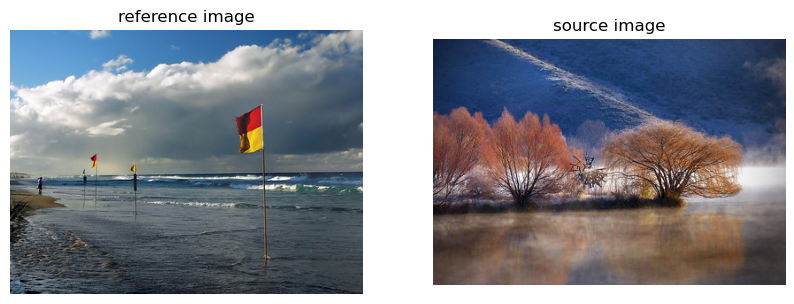

In [468]:
img_ref = Image_d("drapeau.jpg")
img_src = Image_d("arbre.jpg")
img_ref.extract_image()
img_src.extract_image()
Image_d.display(("reference image", "source image"), img_ref, img_src)

<!-- ### Plot histograms -->

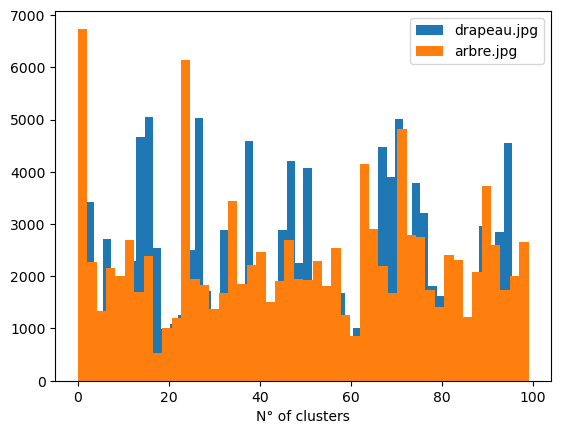

In [469]:
n_ref = 100
n_src = 100

img_ref.fit_kmeans(n_clusters = n_ref)
img_src.fit_kmeans(n_clusters = n_src)
img_ref.plot_histogram()
img_src.plot_histogram()

<!-- Building of matrix $(C_{i,j})_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket} = (d(\hat{\mathbf{x}}_i^{\text{ref}}, \hat{\mathbf{x}}_j^{\text{src}}))_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket}$ where $\hat{\mathbf{x}}_i^{\text{ref}}$ is the i-th centroid  of the reference image and $\hat{\mathbf{x}}_j^{\text{src}}$ is the j-th centroid of the source image. -->

In [470]:
a = img_src.hist[0]/np.sum(img_src.hist[0])
b = img_ref.hist[0]/np.sum(img_ref.hist[0])

In [471]:
gamma_L = [1e-3,1e-2,1e-1,1e0,1e1] #try for differents gamma
Time_ent = [37.4, 17.5, 17.842004776000977, 37.8, 34.26097750663757]
Time_l2 = [31.932182550430298, 8.77163553237915, 3.7722818851470947, 3.1, 1.24]
gamma = gamma_L[0]

### Regular Optimal Transport

In [472]:
def mean_vector(T: np.ndarray, y: np.ndarray):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list n x m)
        y : cluster of the source (or reference) image
    Outputs : 
        solution of the barycentric problem projection
    """
    return T@y/np.sum(T, axis = 1)[:,None]


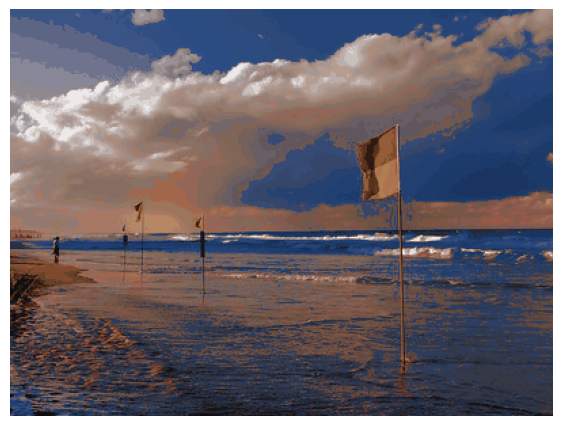

In [473]:
ROT = Regular_OT(img_src, img_ref)

ROT.solve()

ROT.plot_img_transp()

The transport map is 98.00999999999999% sparse


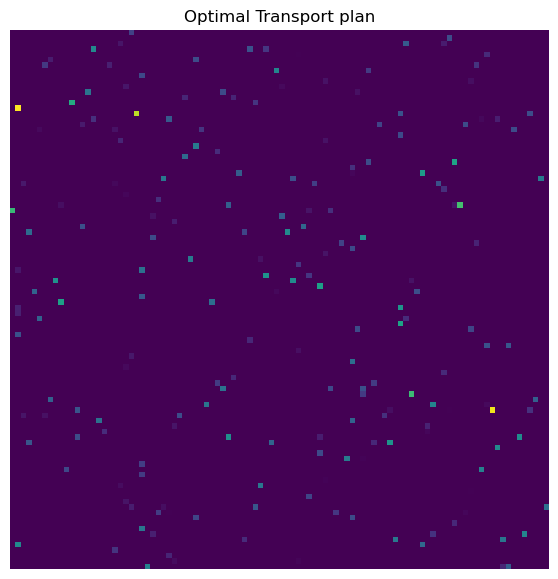

In [474]:
ROT.print_OT_map()
ROT.print_sparsity()

<!-- Plot of $||T_{dual} - T^\star||$ -->

## Dual formulation


I solve here the smoothed dual problem : 
$$
\max_{\mathbf{\alpha} \in \mathbf{R}^m, \mathbf{\beta} \in \mathbf{R}^n} \mathbf{\alpha}^{\top} \mathbf{a} + \mathbf{\beta}^{\top} b - \sum\limits_{j = 1}^{n}\delta_{\Omega}(\mathbf{\alpha} + \beta_j \mathbf{1}_m - \mathbf{c}_{\cdot,j})
$$
A L-BFGS method is applied.

### l2 regularization

Total time spent is: 13.93342924118042


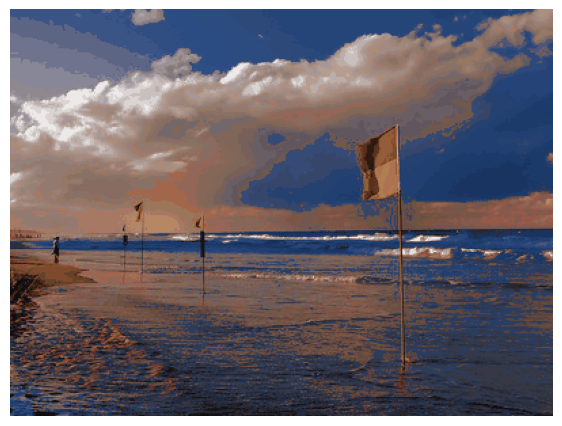

In [475]:
D = Dual_OT(img_src, img_ref, 'BFGS')
D.solve(1e-3, regul='l2')

D.plot_img_transp()

The transport map is 98.00999999999999% sparse


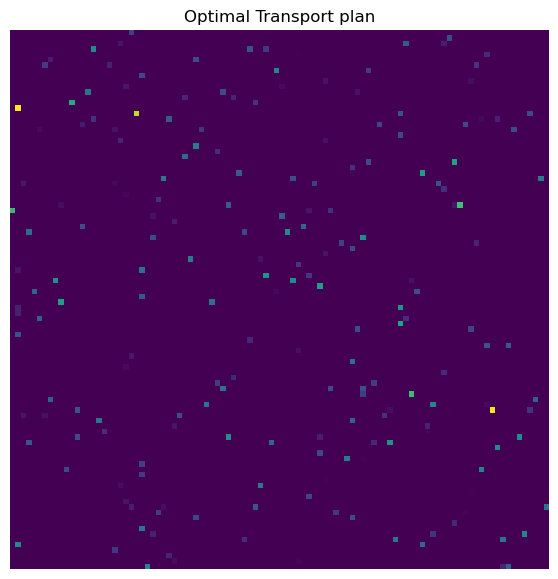

In [476]:
D.print_OT_map()
D.print_sparsity()

### Entropy regularization

Total time spent is: 1.4990870952606201


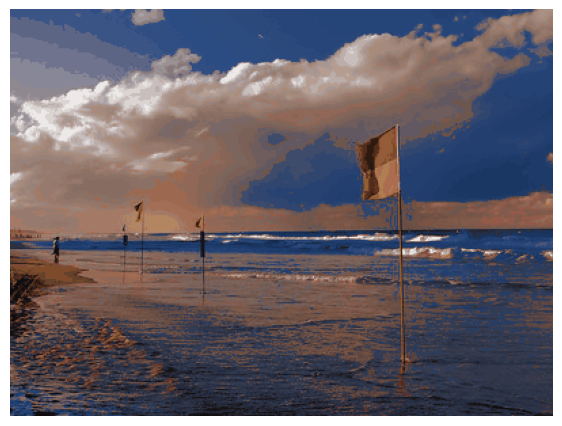

In [477]:
D = Dual_OT(img_src, img_ref, 'BFGS')
D.solve(1e-3, regul='entropy')

D.plot_img_transp()

The transport map is 91.5% sparse


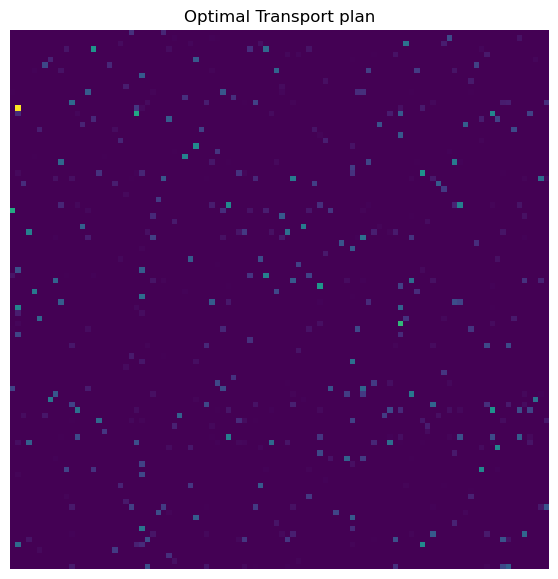

In [478]:
D.print_OT_map()
D.print_sparsity()

## Semi-Dual formulation

We now have here the semi-dual formulation : 
$$
OT(\mathbf{a},\mathbf{b}) = \sup_{\alpha \in \mathbf{R}^m} \mathbf{\alpha}^{\top}a - OT^*(\mathbf{\alpha},\mathbf{b})
$$
Where $OT^*(\mathbf{\alpha},\mathbf{b}) = \sup\limits_{\mathbf{a} \in \Delta_m} \mathbf{a}^{\top} \alpha - OT(\mathbf{a},\mathbf{b})$.
The semi-dual formulation has a closed expression, starting from the observation that :
$
OT^*(\mathbf{\alpha},\mathbf{b}) = \sum\limits_{j = 1}^{n} b_j \max_{\Omega_j}(\mathbf{\alpha} - \mathbf{c}_{\cdot,j})
$
, where $\Omega_j(y) = \frac{1}{b_j}\Omega(b_jy)$.
Eventually, the final optimization problem to solve is :
$
OT(\mathbf{a},\mathbf{b}) = \sup\limits_{\mathbf{\alpha} \in \mathbf{R}^m} \mathbf{a}^{\top} \alpha - \sum\limits_{j = 1}^{n} b_j \max_{\Omega_j}(\mathbf{\alpha} - \mathbf{c}_{\cdot,j})
$
In a similar way as before, the primal optimal is related to the dual optimal thanks to the relation : 
$
\mathbf{t}_j^* = b_j\nabla \max_{\Omega_j}(\alpha^* - \mathbf{c}_{\cdot,j})
$

### l2 Regularization

Total time spent is: 4.06220555305481


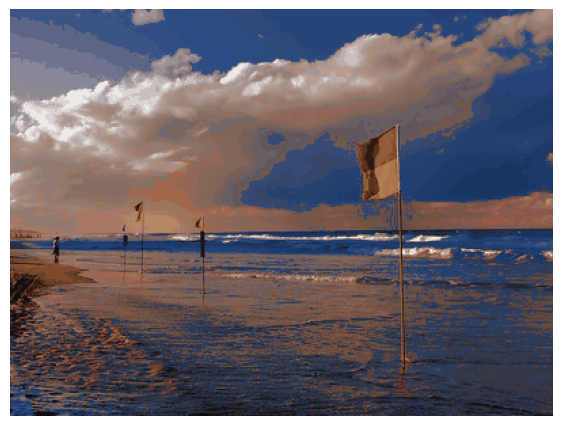

In [479]:
D = Semi_Dual_OT(img_src, img_ref, 'BFGS')
D.solve(1e-3, regul = "l2")

D.plot_img_transp()

The transport map is 98.00999999999999% sparse


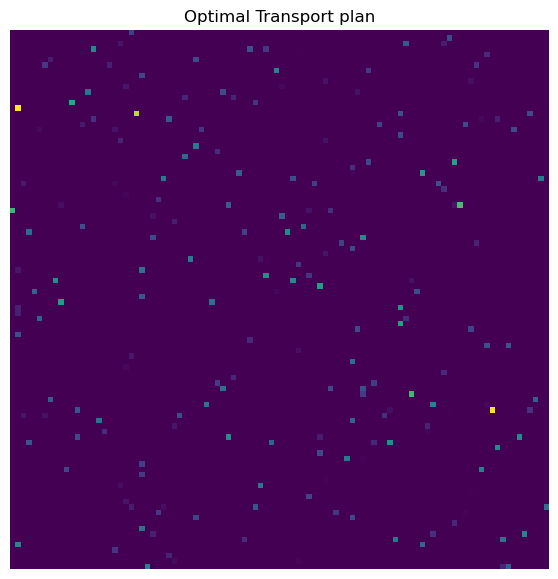

In [480]:
D.print_OT_map()
D.print_sparsity()

### Entropy regularization

Total time spent is: 0.30208516120910645


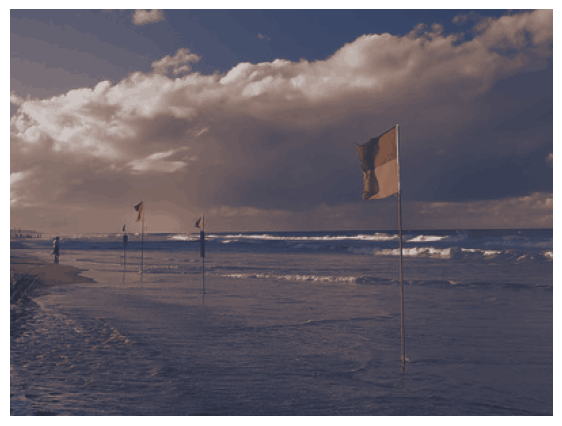

In [481]:
D = Semi_Dual_OT(img_src, img_ref, 'BFGS')
D.solve(.1, regul = "entropy")

D.plot_img_transp()

The transport map is 7.62% sparse


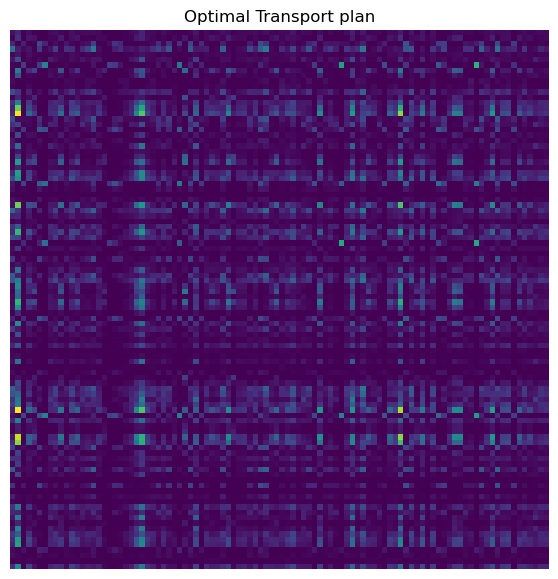

In [482]:
D.print_OT_map()
D.print_sparsity()

## Check upper and lower bound on error.

In [483]:
gamma_L = [1e-3,5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0] #try for differents gamma

### Entropy bounds

In [495]:
def ent(a):
    return -np.sum(a*np.log(a))

a = img_ref.hist[0]/np.sum(img_ref.hist[0])
b = img_src.hist[0]/np.sum(img_src.hist[0])

ent_a = ent(a)
ent_b = ent(b)
#For entropy regularization
L_e = np.dot((ent_a + ent_b), gamma_L)
U_e = np.dot(max(ent_a,ent_b), gamma_L)

value_ent_SD = []
value_ent_D = []

Loss_history_ent_D = []
Loss_history_ent_SD = []


SD = Semi_Dual_OT(img_src, img_ref)
print("Start of calculation for semi-dual formulation\n")
for gamma in gamma_L:
    SD.solve(gamma, regul = "entropy", plot_loss = True)
    value_ent_SD.append(SD.value)
    Loss_history_ent_SD.append(SD.loss_history.copy())
    SD.loss_history = []
print("End of calculation for semi-dual formulation\n")

D = Dual_OT(img_src, img_ref)
print("Start of calculation for dual formulation\n")
for gamma in gamma_L:
    D.solve(gamma, regul = "entropy", plot_loss = True)
    value_ent_D.append(D.value)
    Loss_history_ent_D.append(D.loss_history.copy())
    D.loss_history = []
print("End of calculation for dual formulation")

error_ent_sd = np.abs(value_ent_SD - ROT.value)
error_ent_d = np.abs(value_ent_D - ROT.value)

Start of calculation for semi-dual formulation

Total time spent is: 0.8639123439788818
Total time spent is: 0.5980684757232666
Total time spent is: 0.3710634708404541
Total time spent is: 0.33205580711364746
Total time spent is: 0.4518857002258301
Total time spent is: 0.8972921371459961
Total time spent is: 1.1546931266784668
End of calculation for semi-dual formulation

Start of calculation for dual formulation

Total time spent is: 2.2434370517730713
Total time spent is: 0.8819239139556885
Total time spent is: 0.74462890625
Total time spent is: 0.5200259685516357
Total time spent is: 1.5801584720611572
Total time spent is: 2.553659200668335
Total time spent is: 3.1698250770568848
End of calculation for dual formulation


The two lines perfectly overlap each other.

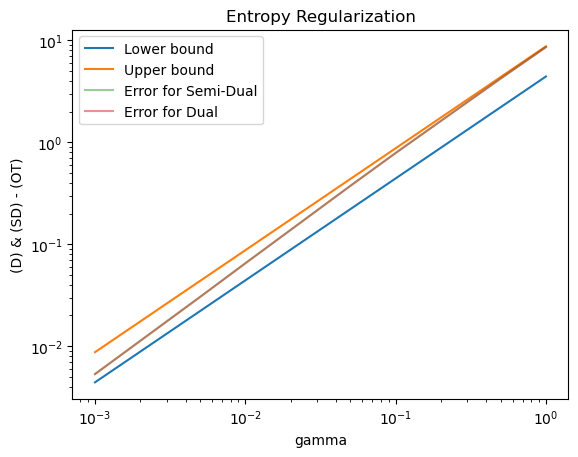

In [485]:
plt.loglog(gamma_L,U_e, label = 'Lower bound')
plt.loglog(gamma_L,L_e, label = 'Upper bound')
plt.loglog(gamma_L,error_ent_sd, label = 'Error for Semi-Dual', alpha = .5)
plt.loglog(gamma_L,error_ent_d, label = 'Error for Dual', alpha = .5)
plt.xlabel('gamma')
plt.title("Entropy Regularization")
plt.ylabel('(D) & (SD) - (OT)')
plt.legend()

### Plot of loss history

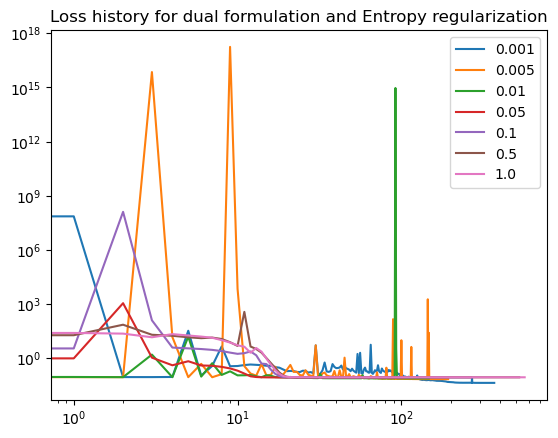

In [496]:
for i, g in enumerate(gamma_L):
    plt.loglog(Loss_history_ent_D[i], label = str(g))
    plt.legend()
    plt.title("Loss history for dual formulation and Entropy regularization")

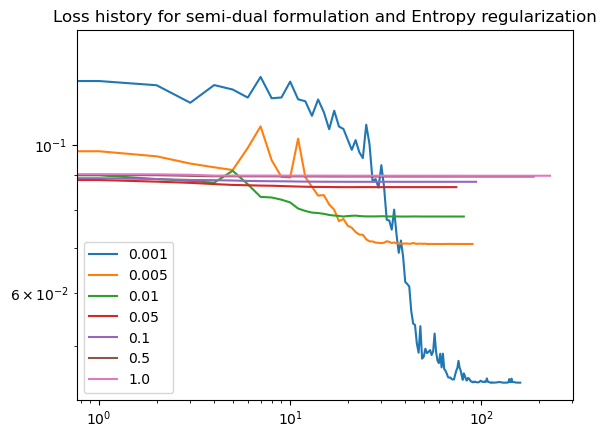

In [497]:
for i, g in enumerate(gamma_L):
    plt.loglog(Loss_history_ent_SD[i], label = str(g))
    plt.legend()
    plt.title("Loss history for semi-dual formulation and Entropy regularization")

### l2 bounds

In [492]:
#For squared-norm regularization
L_n = 1/2*np.sum([(a[i]/n_ref + b[j]/n_src - 1/(n_src*n_ref))**2 for i in range(len(a)) for j in range(len(b))])*np.array(gamma_L)
U_n = (np.min((np.sum(a**2), np.sum(b**2))))*np.array(gamma_L)

value_l2_SD = []
value_l2_D = []

Loss_history_l2_D = []
Loss_history_l2_SD = []

SD = Semi_Dual_OT(img_src, img_ref)
print("Start of calculation for semi-dual formulation")
for gamma in gamma_L:
    SD.solve(gamma, regul = "l2", plot_loss=True)
    value_l2_SD.append(SD.value)
    Loss_history_l2_SD.append(SD.loss_history)
    SD.loss_history = []
print("End of calculation for semi-dual formulation")
print('\n')
print("Start of calculation for dual formulation")
D = Dual_OT(img_src, img_ref)
for gamma in gamma_L:
    D.solve(gamma, regul = "l2", plot_loss=True)
    value_l2_D.append(D.value)
    Loss_history_l2_D.append(D.loss_history)
    D.loss_history = []
print("End of calculation for dual formulation")

error_l2_sd = np.abs(value_l2_SD - ROT.value)
error_l2_d = np.abs(value_l2_D - ROT.value)

Start of calculation for semi-dual formulation
Total time spent is: 7.767906427383423
Total time spent is: 6.006364822387695
Total time spent is: 6.154732942581177
Total time spent is: 4.938257455825806
Total time spent is: 4.696379661560059
Total time spent is: 4.334860563278198
Total time spent is: 3.765185832977295
End of calculation for semi-dual formulation


Start of calculation for dual formulation
Total time spent is: 19.130271196365356
Total time spent is: 8.924553632736206
Total time spent is: 7.005747079849243
Total time spent is: 3.7579996585845947
Total time spent is: 2.7156248092651367
Total time spent is: 1.9429335594177246
Total time spent is: 1.6100244522094727
End of calculation for dual formulation


The two lines perfectly overlap each other.

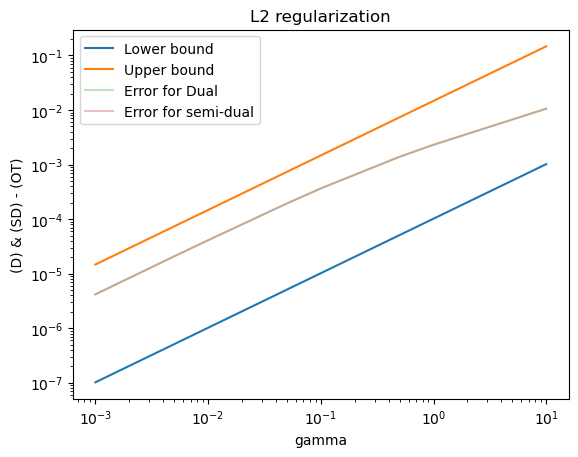

In [229]:
plt.loglog(gamma_L,L_n, label = 'Lower bound')
plt.loglog(gamma_L,U_n, label = 'Upper bound')
plt.loglog(gamma_L,error_l2_d, label = 'Error for Dual', alpha=0.3)
plt.loglog(gamma_L, error_l2_sd, label = "Error for semi-dual", alpha=0.3)
plt.xlabel('gamma')
plt.title('L2 regularization')
plt.ylabel('(D) & (SD) - (OT)')
plt.legend()

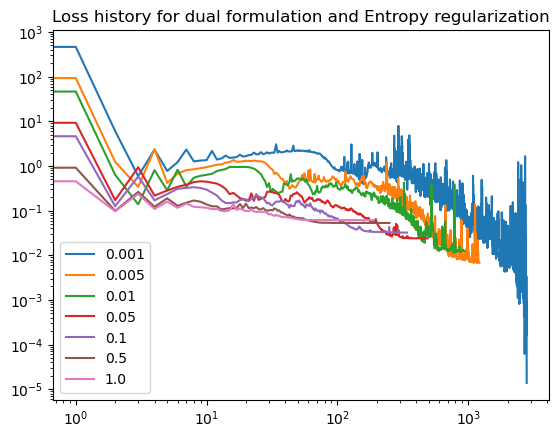

In [493]:
for i, g in enumerate(gamma_L):
    plt.loglog(Loss_history_l2_D[i], label = str(g))
    plt.legend()
    plt.title("Loss history for dual formulation and Entropy regularization")

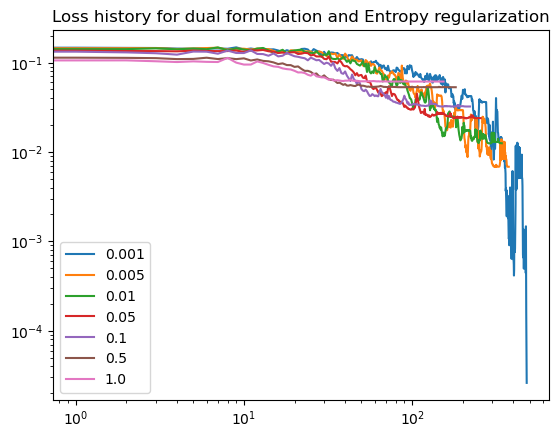

In [494]:
for i, g in enumerate(gamma_L):
    plt.loglog(Loss_history_l2_SD[i], label = str(g))
    plt.legend()
    plt.title("Loss history for dual formulation and Entropy regularization")

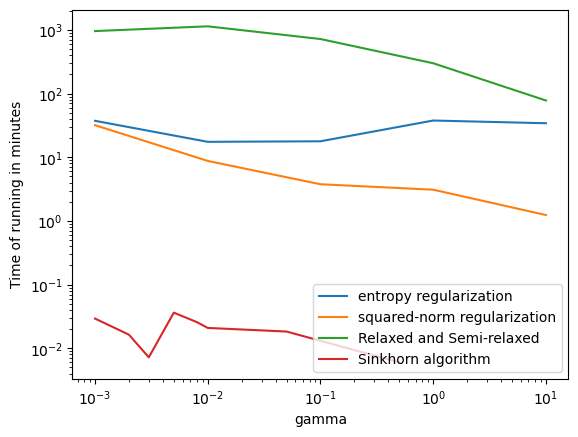

In [119]:
Time_ent = [37.4, 17.5, 17.842004776000977, 37.8, 34.26097750663757]
gamma_L2 = [1e-3,2e-3,3e-3,5e-3,8e-3,1e-2,5e-2,5e-1]
Time_l2 = [31.932182550430298, 8.77163553237915, 3.7722818851470947, 3.1, 1.24]
Time_rel = [16*60, 19*60, 12*60, 5*60, 1.3*60]
Time_sinkhorn = [0.029334306716918945,
 0.016376018524169922,
 0.007218360900878906,
 0.036338090896606445,
 0.0258333683013916,
 0.020913362503051758,
 0.018347501754760742,
 0.006028890609741211]
plt.plot(gamma_L, Time_ent, label = 'entropy regularization')
plt.plot(gamma_L, Time_l2, label = 'squared-norm regularization')
plt.plot(gamma_L, Time_rel, label = 'Relaxed and Semi-relaxed ')
plt.plot(gamma_L2, Time_sinkhorn, label = 'Sinkhorn algorithm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma')
plt.ylabel('Running time in seconds')
plt.legend()

### Primal Entropic regularization

To have a primal with strong convexity, one adds a strongly convex function $\Omega$, function of the column of T.
It then becomes : 
$$
OT_{\Omega}(a,b) = \min\limits_{P \in \mathcal{U}(a,b)} \langle P,C \rangle + \sum\limits_{j = 1}^n \Omega(\mathbf{t}_j)
$$
We then want to solve it via Sinkhorn algorithm in the case of entropic regularization.

Entropy break down the rule of natural sparsity : this implies in particular that the resulting P matrix is sparse, for instance one can show that there are always
solutions with less than n + m − 1 non-zero elements
Speeding Up Sinkhorn’s Iterations 
Parallel and GPU friendly computation

gamma is  0.001
Total time spent is: 0.007997989654541016
gamma is  0.002
Total time spent is: 0.0039899349212646484
gamma is  0.003
Total time spent is: 0.006966829299926758
gamma is  0.005
Total time spent is: 0.004000425338745117
gamma is  0.008
Total time spent is: 0.0019996166229248047
gamma is  0.01
Total time spent is: 0.003000020980834961
gamma is  0.05
Total time spent is: 0.0029969215393066406
gamma is  0.5
Total time spent is: 0.0019998550415039062
gamma is  0.1
Total time spent is: 0.002001047134399414


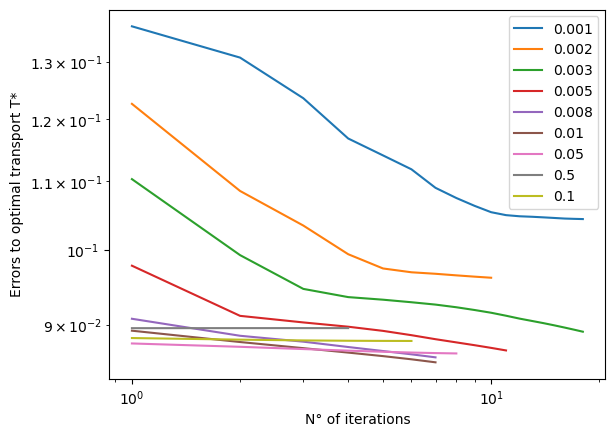

In [501]:
E_OT = Entropy_OT(img_src, img_ref)
gamma_L = [1e-3,2e-3,3e-3,5e-3,8e-3,1e-2,5e-2,5e-1,1e-1]
n_iter = 0
u_init = np.ones((n_ref))
v_init = np.ones((n_src))
eps = 0.001
Time_sinkhorn = []
for g in gamma_L:
    print("gamma is ", g)
    n_iter = E_OT.solve(u_init, v_init, g, eps, plot_loss=True)
    N = np.linspace(1,n_iter,n_iter)
    plt.loglog(N, E_OT.loss_history, label = str(g))
    E_OT.loss_history = []
    plt.xlabel('N° of iterations')
    plt.ylabel('Errors to optimal transport T*')
plt.legend(loc = 'upper right')

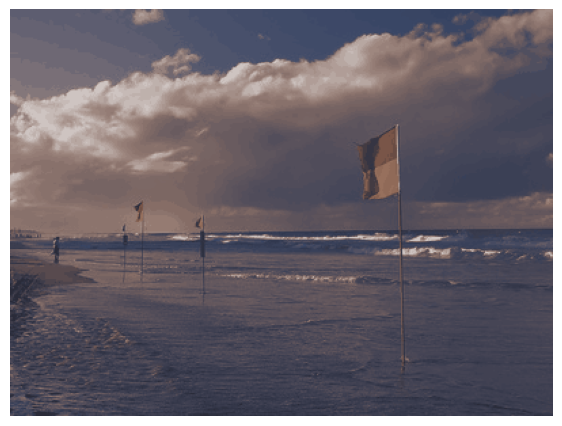

In [208]:
E_OT.plot_img_transp()

You can see we gained in algorithmic efficiency but lost the sparse property of the transport plan.

The transport map is 7.5% sparse


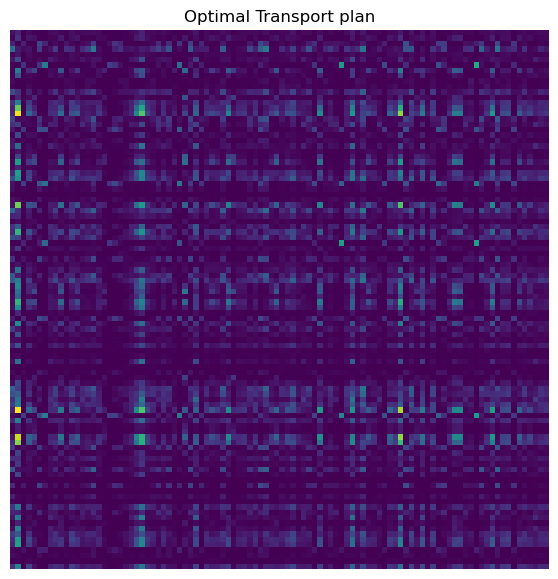

In [210]:
E_OT.print_OT_map()
E_OT.print_sparsity()

Total time spent is: 2.4522500038146973


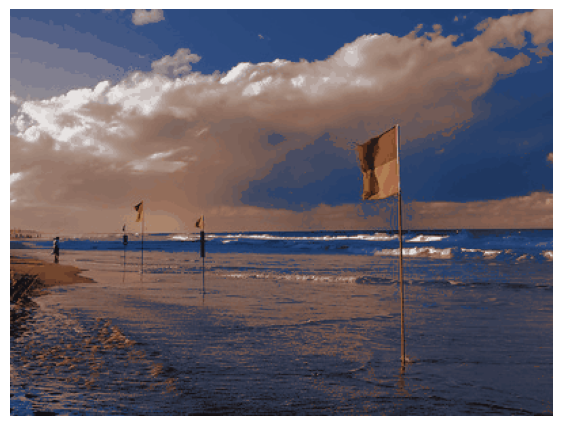

In [211]:
SD = Semi_Dual_OT(img_src, img_ref, 'BFGS')
SD.solve(gamma)

SD.plot_img_transp()

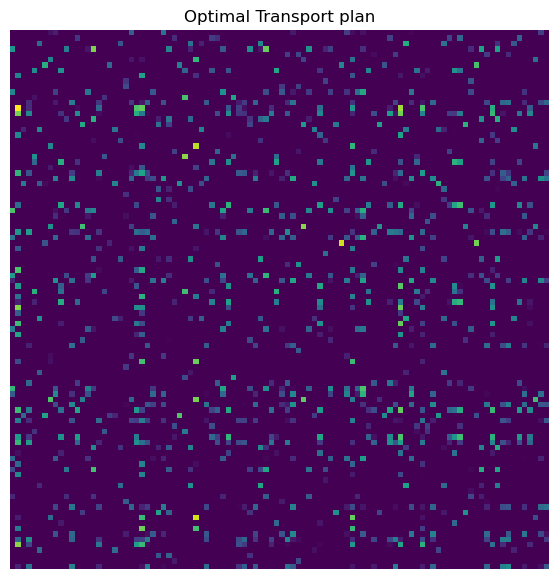

In [212]:
SD.print_OT_map()

### Relaxed smooth primal

One decide to not take into account the equality constraint at all anymore (only the positive one), and decide to make add an explicit penalisation on the objective function.
Therefore, we introduce :
$$
ROT_{\Phi}(\mathbf{a},\mathbf{b})= \min_{T \geq 0} \langle T,C \rangle + \frac{1}{2}(\Phi(T\mathbf{1}_n, \mathbf{a}) + \Phi(T^{\top}\mathbf{1}_m, \mathbf{b}))
$$ and its semi-relaxed version :
$$
\widetilde{ROT}_{\Phi}(\mathbf{a}, \mathbf{b}) = \min_{\begin{array}{c} T \geq 0;\\ T^{\top}\mathcal{1}_n = b  \end{array}} \langle T,C \rangle + \frac{1}{2}\Phi(T\mathbf{1}_n,a) 
$$
In our case, we will take $\Phi(\mathbf{x}, \mathbf{y}) = \frac{1}{2\gamma}||\mathbf{x} - \mathbf{y}||^2$. Once again, $\gamma$ will be the parameter of our penalisation. Of course, we expect : $\lim\limits_{\gamma \rightarrow 0} T_{\Phi,\gamma}^* = T^*$ and $\lim\limits_{\gamma \rightarrow 0} \tilde{T}_{\Phi,\gamma}^* = T^*$

See dedicated nootebook for details.

In [317]:
Rel_OT = relaxed_OT(img_src, img_ref)

Rel_OT.solve(gamma)

Rel_OT.plot_img_transp()